#**Fruit classifier**

###**Imports and Base Dataset upload**

In [81]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, label_binarize
import matplotlib.pyplot as plt

from google.colab import files
import io

# For Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# For Decision Tree model
from sklearn import decomposition
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


In [82]:
uploaded    = files.upload()
df_fruits   = pd.read_excel('fruit_data.xlsx')

Saving fruit_data.xlsx to fruit_data (4).xlsx


###**Data understanding and preparation**

In [83]:
# We take a look at the first couple rows of the dataframe
df_fruits.head()

,Unnamed: 0,fruit_type,color,size,weight
0,0,grape,Yellow,Tiny,8.303385
1,1,apple,Pink,Largee,80.976370
2,2,banana,Pale Yellow,Large,74.615192
3,3,grape,Red,Tiny,6.924070
4,4,banana,Creamy White,Largee,82.002542


In [84]:
# For simplfying the dataframe, we can discard the first column of indexes, since
# we don't need it. Additionaly we can move the target column "fruit_type" to right
columns       = ["color", "size", "weight", "fruit_type"]
df_fruits     = df_fruits[columns]

df_fruits.head()

,color,size,weight,fruit_type
0,Yellow,Tiny,8.303385,grape
1,Pink,Largee,80.976370,apple
2,Pale Yellow,Large,74.615192,banana
3,Red,Tiny,6.924070,grape
4,Creamy White,Largee,82.002542,banana


In [85]:
# We take a look at the list of unique values from the columns fruit_type, color and size
for column_name in df_fruits.columns[:2]:
  print(column_name, df_fruits[column_name].unique(), "\n")

color ['Yellow' 'Pink' 'Pale Yellow' 'Red' 'Creamy White' 'Green' 'Yellow1'
 'Purple' 'Black'] 

size ['Tiny' 'Largee' 'Large' 'Small' 'Medium'] 



Here we can immediately identify two issues, the first being that the column "color" has the value "Yellow1" in some rows. We can assume this is a spelling mistake and should be replaced with "Yellow". The same goes for the value "Largee" which should be replaced with "Large" in the column "size".

In [86]:
# We proceed to replace the values with the correct spelling

# Replacing "Yellow1" with "Yellow" in the column "color"
df_fruits.loc[df_fruits["color"] == "Yellow1", "color"] = "Yellow"

# Replacing "Largee" with "Large" in the column "size"
df_fruits.loc[df_fruits["size"] == "Largee", "size"] = "Large"

# We check again for the unique values
for column_name in df_fruits.columns[:2]:
  print(column_name, df_fruits[column_name].unique(), "\n")


color ['Yellow' 'Pink' 'Pale Yellow' 'Red' 'Creamy White' 'Green' 'Purple'
 'Black'] 

size ['Tiny' 'Large' 'Small' 'Medium'] 



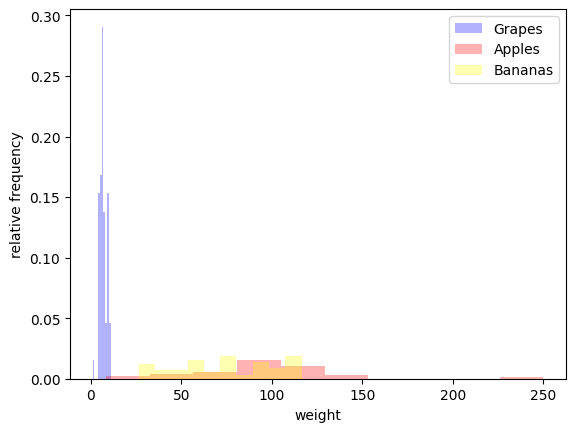

In [87]:
# Now we take a look at the column "weight", ideally since we have only 3 types
# of fruits we can also separate the values by this label.

plt.hist(df_fruits[df_fruits['fruit_type']=="grape"]["weight"],   color='blue',   label="Grapes",   density=True, alpha=0.3)
plt.hist(df_fruits[df_fruits['fruit_type']=="apple"]["weight"],   color='red',    label="Apples",   density=True, alpha=0.3)
plt.hist(df_fruits[df_fruits['fruit_type']=="banana"]["weight"],  color='yellow', label="Bananas",  density=True, alpha=0.3)

plt.xlabel("weight")
plt.ylabel("relative frequency")
plt.legend()
plt.show()

Through looking at this histogram, we can notice an overall normal distribution of weight except for the presence of a far from normal value in the range of 225-250 in the weight axis.

In [88]:
# We print the rows with a feature of weight greater than 200, since as observed
# in the histogram this is where the outliers are found

df_fruits[df_fruits["weight"] > 200]

,color,size,weight,fruit_type
26,Green,Small,250.0,apple
33,Yellow,Medium,250.0,apple


Given that only two rows are presenting abnormal values, we can discard these for the sake of optimizing the classifier model to be as general as possible and therefore probably more accurate

In [89]:
#At first the dataframe has this amount of inputs
print("Rows in original dataframe:   ", len(df_fruits))
print("Rows in outliers dataframe:  ", 0)

# We create the condition that determines if the inputs is an outlier
outliers_condition    = df_fruits['weight'] > 200

# We store the outlier input in another dataframe so that we don't lose them
df_fruits_outliers    = df_fruits[outliers_condition]

# We remove the outlier rows from the original dataframe
df_fruits             = df_fruits[~outliers_condition]

# We save the list of target classes for later
target_class_list     = df_fruits["color"].unique()

# We check again
print("Rows in original dataframe:  ", len(df_fruits))
print("Rows in outliers dataframe:  ", len(df_fruits_outliers))

Rows in original dataframe:    200
Rows in outliers dataframe:   0
Rows in original dataframe:    198
Rows in outliers dataframe:   2


One-hot-encoding of the columns "color" and "size"

In [90]:
# Manual one hot encoding for the column "color"
for color in df_fruits["color"].unique():
  df_fruits.loc[df_fruits["color"] == color, color] = 1;
  df_fruits.loc[df_fruits["color"] != color, color] = 0;

# Manual one hot encoding for the column "size"
for size in df_fruits["size"].unique():
  df_fruits.loc[df_fruits["size"] == size, size] = 1;
  df_fruits.loc[df_fruits["size"] != size, size] = 0;

# Discarding the columns with categorical values and leaving target column at the end again
columns_list    = []
for dummie_column in df_fruits.columns[4:]: columns_list.append(dummie_column)

columns_list.extend(["weight", "fruit_type"])

df_fruits       = df_fruits[columns_list]

df_fruits.head()

,Yellow,Pink,Pale Yellow,Red,Creamy White,Green,Purple,Black,Tiny,Large,Small,Medium,weight,fruit_type
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.303385,grape
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,80.976370,apple
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,74.615192,banana
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.924070,grape
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,82.002542,banana


Creation of train, validation and test datasets

In [91]:
# We use train_test_split() to split our original dataframe into the sections of
# training and testing. In this case, we set the training size on 80% of the
# total input and the testing section is 20%.

# First we separate the feature matrix (X) from the target vector (y)
X = df_fruits[df_fruits.columns[:-1]].values
y = df_fruits[df_fruits.columns[-1]].values

# We use train_test_split function from sklearn to divide the "X" and "y" into
# train and test sections
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42)

# We create a scaler object that we later on use for scaling the feature matrixes
scaler      = StandardScaler()
X_train     = scaler.fit_transform(X_train)
X_test      = scaler.fit_transform(X_test)

###**Modeling and Analysis**
In order to ensure the reproducibility of the model's performance, in both cases we use the "random_state" hyperparameter set to 42

Using the **Logistic Regression Model**

In [93]:
# Creating the Logistic regression classifier
log_model     = LogisticRegression(random_state=42, C=1.0, fit_intercept=True, penalty='l2', solver='lbfgs', multi_class="ovr")

# Training the model
log_model     = log_model.fit(X_train, y_train)

Using the **Decision Tree Model**

In [94]:
# Creating the Decision tree classifier
clf_model     = DecisionTreeClassifier(random_state=42)

# Training the model
clf_model     = clf_model.fit(X_train, y_train)

###**Model performance and interpretation**
In this block, both models are executed and tested. The performance report in terms of accuracy, f1 score and ROC-AUC is also shown

In [101]:
y_pred        = log_model.predict(X_test)
print(np.unique(y_pred))

['apple' 'banana' 'grape']


In [105]:
# Logistic regression model execution and report
y_pred        = log_model.predict(X_test)
print("Report for logistic regression model - - - - - - - - - - -")
print(classification_report(y_test, y_pred))
print('')
print('ROC-AUC result:', roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), label_binarize(y_pred, classes=np.unique(y_pred)), multi_class='ovr', average='macro'))
print('')
print('')

# Decision tree model execution and report
y_pred        = clf_model.predict(X_test)
print("Report for decision tree model - - - - - - - - - - - - - -")
print(classification_report(y_test, y_pred))
print('')
print('ROC-AUC result:', roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), label_binarize(y_pred, classes=np.unique(y_pred)), multi_class='ovr', average='macro'))

Report for logistic regression model - - - - - - - - - - -
              precision    recall  f1-score   support

       apple       0.56      0.69      0.62        13
      banana       0.69      0.56      0.62        16
       grape       1.00      1.00      1.00        11

    accuracy                           0.73        40
   macro avg       0.75      0.75      0.75        40
weighted avg       0.73      0.72      0.72        40


ROC-AUC result: 0.8048136277302943


Report for decision tree model - - - - - - - - - - - - - -
              precision    recall  f1-score   support

       apple       0.45      0.38      0.42        13
      banana       0.56      0.62      0.59        16
       grape       1.00      1.00      1.00        11

    accuracy                           0.65        40
   macro avg       0.67      0.67      0.67        40
weighted avg       0.64      0.65      0.65        40


ROC-AUC result: 0.7423433048433048


As final thoughts on the results, we can appreciate a subtle but better performance coming from the Logistic Regresion Model. We base this on the higher accuracy, f1 score and ROC-AUC performance metrics. We can also notice that in both models, the accuracy for correctly classifing the grapes is noticeably higher than the rest, and at the same time, both apples and bananas are having really low scores in comparison.

From this we can assume that the similarities in the features of the apples and bananas make the models incur into many problems differentiating them, at least in a considerable amount of cases.